In [42]:
%load_ext autoreload
%autoreload 2

from rknot.dots import MATRIX_COL_LABELS as ML
from rknot.notebook import *
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

plt.style.use('rknot_nb')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Seasonality ##

There are many viruses that exhibit seasonality. In particular, in (northern??) North America, influenza and the common cold ([which is a catch-all for a collection of ~different virus strains](https://en.wikipedia.org/wiki/Common_cold)) predictably peak in the winter months and subside in the summer. The reasons for the seasonality of these viruses (and not others) is still somewhat of a mystery, but [the Harvard School Public Health provides a summary of potential factors here](https://ccdd.hsph.harvard.edu/will-covid-19-go-away-on-its-own-in-warmer-weather).

**Natural Progression of Immunity**

+ remarkably, the most relevant factor may have nothing at all to do with seasonality. A virus and its host population may have an immunity profile that results in an intrinsic ebb and flow of infections (that may or may not line up with typical regional seasons). For instance, [influenza immunity is believed to last for 3 months](https://www.cdc.gov/flu/professionals/acip/immunogenicity.htm#Duration), meaning that the potential host population subsides and then increases in time for the virus to reemerge months later (to say nothing of the different types of influenza that might be prevalent during any season).

**Geological / Meteorological Factors**

+ Lower humidity has been shown to slow influenza spread although very high humditiy has been shown to increase it in tropical regions.
+ [Sun exposure and temperature have also been shown to impact influenza prevalence](https://ehp.niehs.nih.gov/doi/pdf/10.1289/ehp.1002383).

**Behavior Changes**

+ In colder environments, people tend to move indoors more frequently in closer quarters and with worse ventalition. In particular, school seasonality in North America aligns with winter.
+ one should also consider that the *warmest* environments might experience inverse behavior changes to the coldest. People in the southern US, for example, may move indoors during the peak of summer to take advantage of air conditioning ([this was suggested by Nate Silver of FiveThirtyEight](https://twitter.com/NateSilver538/status/1273329472524222466)).

**Weakening Immune System**

+ there is limited research but it is also known that melatonin and vitamin D play a role in immune response. So individuals with less exposure to sunshine (whether due to covering up when outdoors or simply being indoors) may result in a greater number of infections.

[Professor Lipsitch of Harvard](https://ccdd.hsph.harvard.edu/will-covid-19-go-away-on-its-own-in-warmer-weather) is also very careful to emphasize that seasonal factors are likely much more relevant in *existing* viruses versus *new* viruses. The sheer size of the susceptible population of a new virus is likely enough to overwhelm the marginal impact of any one or all seasonal factors combined.

That said, even with new viruses, one would expect these factors to provide at least *some* resistance or reinforcement as they case may be.

---
### Location Transmission Factors ###

+ **RKnot** attempts to encapsulate the various factors above through a transmission factor associated with each location in the Grid. To account for seasonal changes, a separate transmission factor for each tick in the simulation can be assigned.
+ The result is a matrix of shape (# of locations, # of ticks). For now, transmission factors are assigned through the `boxf` attribute of a group and are input as a integer of 100x, consistent with other transmission factors used in the package.

+ Below, we show the `loc_tmf` for simulation with features:
    + 1 group
    + 100 subjects
    + the group's box is identical to the Grid
    + all locations inside the box are assigned a transmission factor of `boxf=200`

In [43]:
from rknot import Sim, Chart
from rknot.parallel.env import Environment as Env
from rknot.space import create_matrix


group = {'n': 100, 'n_inf': 2, 'box': [1,10,1,10], 'box_is_gated': False, 'boxf': 200}
params = {'R0': 1.8,'imndur': 365, 'infdur': 14, 'density': 1, 'days': 150}

env = Env(params['density'], [group], [], params['imndur'], params['R0'], params['infdur'], np.array([]))
env.setup()

locmat, loc_tmf = create_matrix(params['days'], env.boxes, env.gates)

In [44]:
text = 'This results in the matrix below, with shape'
text += f' {loc_tmf.shape}. You can see that each location (rows) has the same'
text += ' transmission factor on each tick (columns).'
md(text)

This results in the matrix below, with shape (100, 150). You can see that each location (rows) has the same transmission factor on each tick (columns).

In [45]:
loc_tmf

array([[200, 200, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200],
       ...,
       [200, 200, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200]], dtype=int32)

Location transmission factors can take on any shape the user desires. In the example below, a series of cosine waves are used to create a single curve with following attributes:

+ season lasting 365 days
+ seasonal variability factor of 2x (lower variability factor leads to greater variability)
+ peak transmission factor occurs in the beginning
+ trough transmission factor occurs at the midpoint

This is meant as a rough approximation of seasonal factors impacting viral spread when spread begins in the middle of winter.

In [46]:
seasonal_range = 365
seasonal_factor = 2

x = np.linspace(0, 1, seasonal_range)
base = np.cos(2*np.pi*x)
s1 = -(1/6)*np.cos(-2*np.pi*3*x)
s2 = (1/48)*np.cos(-2*np.pi*5*x)

mixed = base + s1 + s2
tmf = 1 + mixed / seasonal_factor
tmf = (100*tmf).astype(np.int32)

The code above results in the following:

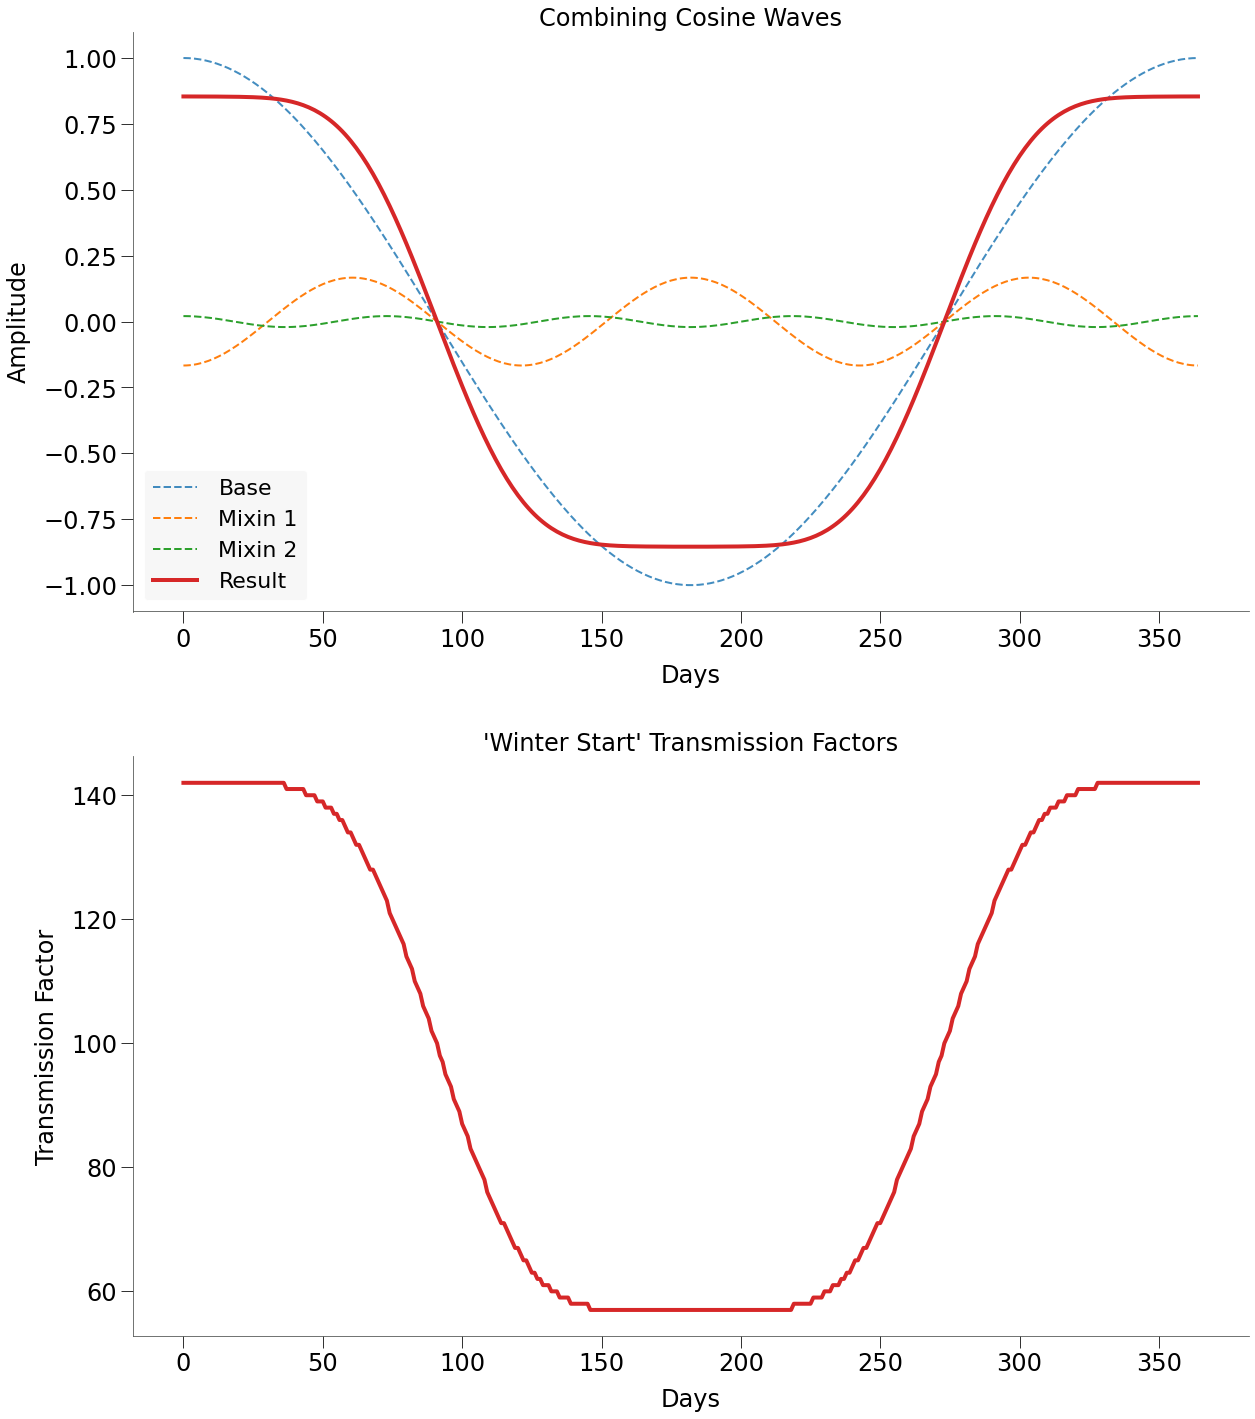

In [49]:
from matplotlib.ticker import FixedLocator

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,24))

ax1.plot(x, base, label='Base', lw=2, ls='--')
ax1.plot(x, s1, label='Mixin 1', lw=2, ls='--')
ax1.plot(x, s2, label='Mixin 2', lw=2, ls='--')
ax1.plot(x, mixed, label='Result', lw=4)

ax1.set_xticks(x)
ax1.set_xticklabels(np.arange(seasonal_range))
ax1.xaxis.set_major_locator(FixedLocator(x[::50]))

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.set_xlabel('Days')
ax1.set_ylabel('Amplitude')
ax1.set_title('Combining Cosine Waves')
ax1.legend(handlelength=2, handletextpad=1)

cycler = plt.rcParams['axes.prop_cycle']
colors = [c['color'] for c in cycler]
ax2.plot(x, tmf, c=colors[3], lw=4)

ax2.set_xticks(x)
ax2.set_xticklabels(np.arange(seasonal_range))
ax2.xaxis.set_major_locator(FixedLocator(x[::50]))

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlabel('Days')
ax2.set_ylabel('Transmission Factor')
ax2.set_title("'Winter Start' Transmission Factors")

fig.subplots_adjust(hspace=.25)

plt.show()

And shown in the `tmf` array below:

In [50]:
tmf

array([142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 141, 141,
       141, 141, 141, 141, 141, 140, 140, 140, 140, 139, 139, 139, 138,
       138, 138, 137, 137, 136, 136, 135, 134, 134, 133, 132, 132, 131,
       130, 129, 128, 128, 127, 126, 125, 124, 123, 121, 120, 119, 118,
       117, 116, 114, 113, 112, 110, 109, 108, 106, 105, 104, 102, 101,
       100,  98,  97,  95,  94,  93,  91,  90,  89,  87,  86,  85,  83,
        82,  81,  80,  79,  78,  76,  75,  74,  73,  72,  71,  71,  70,
        69,  68,  67,  67,  66,  65,  65,  64,  63,  63,  62,  62,  61,
        61,  61,  60,  60,  60,  59,  59,  59,  59,  58,  58,  58,  58,
        58,  58,  58,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,
        57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,
        57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  5

Now we assign that `tmf` array to the `boxf` attribute of our group.

In [9]:
group = {'n': 100, 'n_inf': 2, 'box': [1,10,1,10], 'box_is_gated': False, 'boxf': tmf}
params = {'R0': 1.8,'imndur': 365, 'infdur': 14, 'density': 1, 'days': 365}

env = Env(params['density'], [group], [], params['imndur'], params['R0'], params['infdur'], np.array([]))
env.setup()

locmat, loc_tmf = create_matrix(params['days'], env.boxes, env.gates)

And in the resulting `loc_tmf` matrix, we can see that each location in the Grid has the same dynamic transmission factor across ticks.

In [10]:
loc_tmf[:3, :100]

array([[142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
        142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
        142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 141, 141,
        141, 141, 141, 141, 141, 140, 140, 140, 140, 139, 139, 139, 138,
        138, 138, 137, 137, 136, 136, 135, 134, 134, 133, 132, 132, 131,
        130, 129, 128, 128, 127, 126, 125, 124, 123, 121, 120, 119, 118,
        117, 116, 114, 113, 112, 110, 109, 108, 106, 105, 104, 102, 101,
        100,  98,  97,  95,  94,  93,  91,  90,  89],
       [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
        142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
        142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 141, 141,
        141, 141, 141, 141, 141, 140, 140, 140, 140, 139, 139, 139, 138,
        138, 138, 137, 137, 136, 136, 135, 134, 134, 133, 132, 132, 131,
        130, 129, 128, 128, 127, 126, 125, 124, 123, 121, 120, 119, 11

If we invert the cosine waves, we can invert the seasonality curve, thereby mimicking an outbreak beginning in a region's summer period.

In [14]:
base = -np.cos(2*np.pi*x)
s1 = (1/6)*np.cos(-2*np.pi*3*x)
s2 = -(1/48)*np.cos(-2*np.pi*5*x)

mixed = base + s1 + s2
inv_tmf = 1 + mixed / seasonal_factor
inv_tmf = (100*inv_tmf).astype(np.int32)

This results in the curve below:

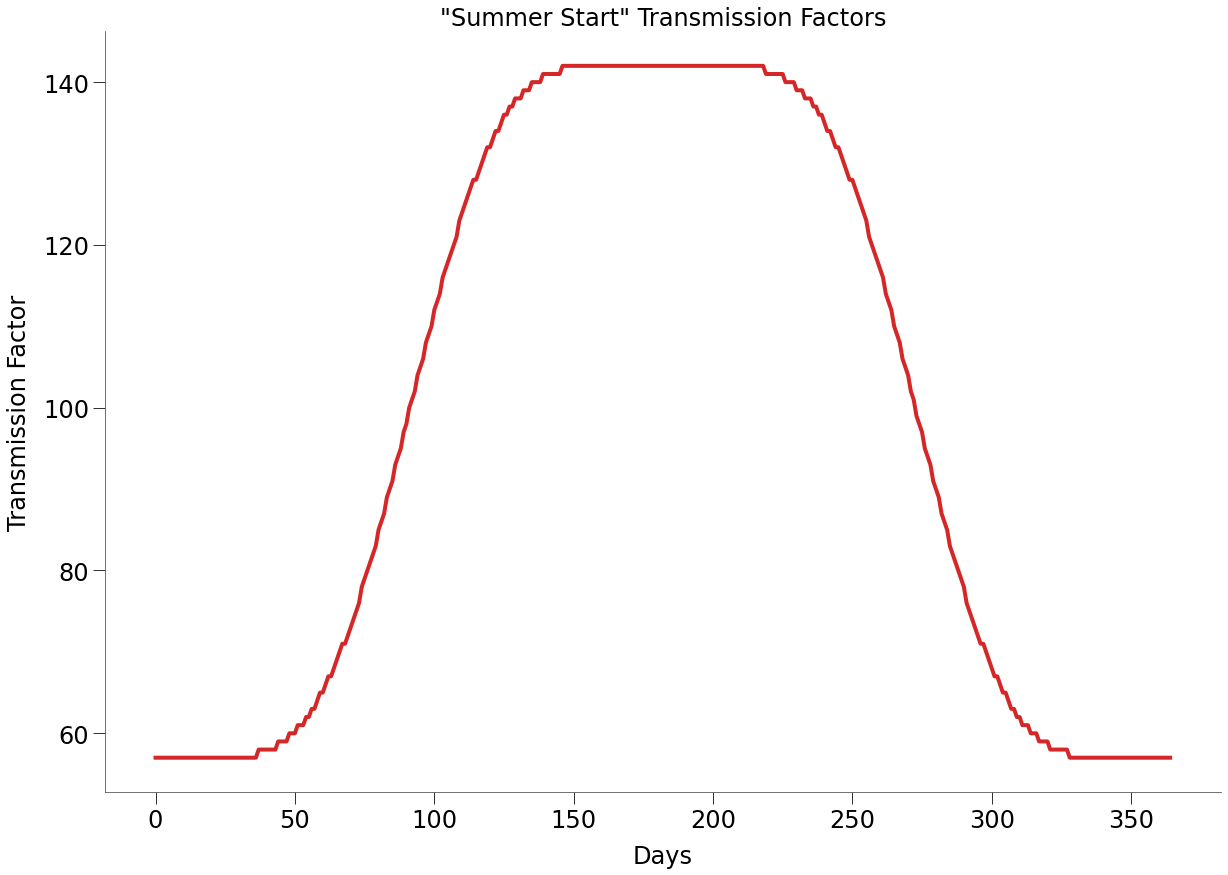

In [54]:
from matplotlib.ticker import FixedLocator

fig, ax = plt.subplots(figsize=(20,14))

ax.plot(x, inv_tmf, c=colors[3], lw=4)

ax.set_xticks(x)
ax.set_xticklabels(np.arange(seasonal_range))
ax.xaxis.set_major_locator(FixedLocator(x[::50]))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Days')
ax.set_ylabel('Transmission Factor')
ax.set_title('"Summer Start" Transmission Factors')

plt.show()

### SIR ###

We'll now utilize our a pair of seasonality curves in some of the standard simulations demonstrated previously. First, we compare outcomes against the basic [Equal Mover scenario from the SIR section](hit.html#1.-Equal).

The seasonal location factors are applied to every location across all groups. To do so, a box is created covering the entire grid and applied to each group by passing the keywords to each group.

First, we create the `params` for the Winter Start seasonality.

In [87]:
gkws = {'box': [1,100,1,100], 'box_is_gated': False, 'boxf': tmf}

group1 = dict(name='0-19', n=2700, n_inf=0, ifr=0.00003, **gkws)
group2 = dict(name='20-49', n=4100, n_inf=1, ifr=0.0002, **gkws)
group3 = dict(name='50-69', n=2300, n_inf=1, ifr=0.005, **gkws)
group4 = dict(name='70+', n=900, n_inf=0, ifr=0.054, **gkws)
w_groups = [group1, group2, group3, group4]

w_params = {
    'groups': w_groups, 'density': 'med', 
    'Ro':2.5, 'days': 365, 'imndur': 365, 'infdur': 14
}

Then, we create the `params` for the Summar Start seasonality.

In [88]:
from copy import deepcopy

s_groups = deepcopy(w_groups)
s_params = deepcopy(w_params)

for group in s_groups:
    group['boxf'] = inv_tmf

s_params['groups'] = s_groups

In [93]:
slug = 'sir_winter'
if False:
    sims = pickloop(
        n=50, sterile=False, save={'path': path, 'slug': slug}, 
        **params
    )

In [94]:
slug_inv = 'sir_summer'
if False:
    sims = pickloop(
        n=50, sterile=False, save={'path': path, 'slug': slug_inv}, 
        **inv_params
    )

In [95]:
slug_flat = 'sir_flat'
if False:    
    flat_group = deepcopy(group)
    flat_params = deepcopy(params)
    
    flat_group.pop('boxf')
    flat_params['groups'] = flat_group
    
    sims = pickloop(
        n=50, sterile=False, save={'path': path, 'slug': slug_flat}, 
        **flat_params
    )

In [75]:
slugs = [slug, slug_inv, slug_flat]
files = [os.path.join(path, 'sims', s + '-pickled') for s in slugs]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    sir_args, sir_sizes, sir_sims = curve_table_inputs(*files)

  0%|          | 0/3 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'vids/seasonality/sims/base-pickled'

We generated 50 simulations encompassing the two seasonal scenarios and the original aseasonal scenario.

In [74]:
headers = [r'SIR<br>Winter<br>$R_0$ > 0', r'SIR<br>Summer<br>$R_0$ > 0', r'SIR<br>Aseasonal<br>$R_0$ > 0'] 
display(HTML(curve_table(headers, sir_args, sir_sizes)))

NameError: name 'sir_args' is not defined

RESTULS!!!!

```python
sim = Sim(**w_params)
sim.run(dotlog=True)
```

In [99]:
path = 'vids/seasonality'
if False:
    sim, res = sim_finder(w_params)

    chart_params = dict(reso_format='web', dotsize=5)
    chart = Chart(
        sim, yscale='tot', show_intro=False, show_restricted=False, **chart_params
    ).save(os.path.join(path, 'tests', f'{slug}_peaks.mp4'))

In [100]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('seasonality/winter_sir')))

In [ ]:
```python
sim = Sim(**s_params)
sim.run(dotlog=True)
```

In [98]:
path = 'vids/seasonality'
if False:
    sim, res = sim_finder(s_params)
    chart_params = dict(reso_format='web', dotsize=5)

    chart = Chart(
        sim, yscale='tot', show_intro=False, show_restricted=False, **chart_params
    ).save(os.path.join(path, 'tests', f'{slug_inv}_peaks.mp4'))

In [70]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('seasonality/summer_sir')))

```python
sim = Sim(**inv_params)
sim.run(dotlog=True)
```

In [101]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('seasonality/winter_sir')))

---
### Events ###

We can easily incorporate these location-based, seasonal transmission factors into more complex structures. Below we incorporate the "summer-like" seasonal factors into our [dynamic load, event-based structure](load.ipynb#Events).

**NOTE**: Seasonal factors cannot be created for locations *not* inside a box. In the event structure, the region where the events occur is inside a VBox, however, the remaining region does *not* occur in a box and so the no transmission factor is applied. The number of contacts outside of the VBox is a very small portion of the total and so should not impact the result materially.

In [22]:
from rknot import Sim, Chart

from rknot.dots.fhutch import tmr
from rknot.sims.us_w_load_18 import events
from rknot.events import Restriction, Quarantine
from rknot.space import create_seasonal_factors

rsxns = []
quars = []
events_loc = []
for e in events:
    if isinstance(e, Restriction):
        rsxns.append(e)
    elif isinstance(e, Quarantine):
        quars.append(e)
    else:
        e.from_boxes = []
        e.no_events = True
        events_loc.append(e)

group1 = dict(name='0-19', n=2700, n_inf=0, ifr=0.00003, mover=.98)
group2 = dict(name='20-49', n=4100, n_inf=1, ifr=0.0002, mover=.98)
group3 = dict(name='50-69', n=2300, n_inf=1, ifr=0.005, mover=.98)
group4 = dict(name='70+', n=900, n_inf=0, ifr=0.054, mover=.98)
groups = [group1, group2, group3, group4]

tmf = create_seasonal_factors()
vbox = {'label': 344, 'box': 344, 'boxf': tmf}
params = {
    'groups': groups, 'density': 1, 
    'days': 365, 'tmr_curve': tmr, 
    'vboxes': vbox, 'events': events_loc,
    'rsxns': rsxns, 
}

```python
sim = Sim(**params)
sim.run()
```

In [23]:
slug = 'events'
path = 'vids/seasonality'
if False:
    chart_params = dict(reso_format='web', dotsize=5)

    chart = Chart(
        sim, yscale='tot', show_intro=False, show_restricted=False, **chart_params
    ).save(os.path.join(path, 'tests', f'{slug}_peaks.mp4'))

In [24]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML(f'seasonality/{slug}')))

In [25]:
inv_tmf = create_seasonal_factors(invert=True)
inv_vbox = {'label': 344, 'box': 344, 'boxf': inv_tmf}
inv_params = deepcopy(params)
inv_params['vboxes'] = inv_vbox

```python
sim = Sim(**inv_params)
sim.run()
```

In [26]:
slug_inv = 'events_inv'
if False:
    chart_params = dict(reso_format='web', dotsize=5)

    chart = Chart(
        sim, yscale='tot', show_intro=False, show_restricted=False, **chart_params
    ).save(os.path.join(path, 'tests', f'{slug_inv}_peaks.mp4'))

In [27]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML(f'seasonality/{slug_inv}')))

In [39]:
if False:
    sims = pickloop(
        n=50, sterile=False, save={'path': path, 'slug': slug}, 
        **params
    )
    sims = pickloop(
        n=50, sterile=False, save={'path': path, 'slug': slug_inv}, 
        **inv_params
    )
    flat_vbox = {'label': 344, 'box': 344}
    flat_params = {
        'groups': groups, 'density': 1, 
        'days': 365, 'tmr_curve': tmr, 
        'vboxes': flat_vbox, 'events': events_loc,
        'rsxns': rsxns, 
    }
    sims = pickloop(
        n=50, sterile=False, save={'path': path, 'slug': 'events_flat'}, 
        **flat_params
    )

In [35]:
slugs = [slug, slug_inv, 'events_flat']
files = [os.path.join(path, 'sims', s + '-pickled') for s in slugs]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    args, sizes, sims = curve_table_inputs(*files, sims_for_each=[])

100%|██████████| 3/3 [00:31<00:00, 10.39s/it]


In [36]:
headers = [r'Winter<br>$R_0$ > 0', r'Summer<br>$R_0$', 'Aseasonal<br>$R_0$'] 
display(HTML(curve_table(headers, args, sizes)))

,Winter$R_0$ > 0,Summer$R_0$,Aseasonal$R_0$
"n, $R_0$ > 0",16,3,16
n,50,50,50
Peak,50.6%,2.3%,33.1%
HIT,56.3%,3.2%,40.8%
Total,64.7%,3.6%,52.8%
Fatalities,0.39%,0.02%,0.35%
%>70,78.8%,53.3%,73.6%
IFR,0.60%,0.45%,0.66%
Days to Peak,62,51,69


In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [41]:
from rknot.notebook import move_to_doc_folder
move_to_doc_folder('seasonal.ipynb')